<a href="https://colab.research.google.com/github/FranzSw/DL-2021/blob/main/gh_notebook_clean2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [3]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

import tensorflow as tf
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from scipy.optimize import fmin_l_bfgs_b

from google.colab import files

tf.compat.v1.disable_eager_execution()

## Upload

In [16]:
content_file = files.upload()
style_file = files.upload()

Saving Robbe-am-Strand-was-nun.jpg to Robbe-am-Strand-was-nun (1).jpg


Saving 36tgWWvg.jpeg to 36tgWWvg.jpeg


## Hyperparameters

In [15]:
content_weight = 0.02
style_weight = 15.0
total_variation_weight = 3.0

## Load and preprocess the content and style images

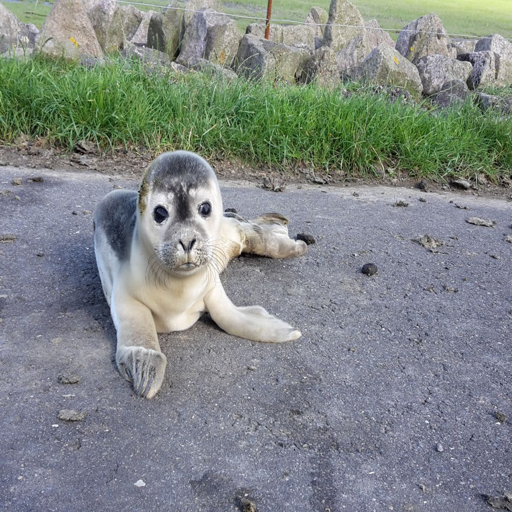

In [18]:
height = 512
width = 512

content_image = Image.open(next(iter(content_file)))
content_image = content_image.resize((width, height))
content_image

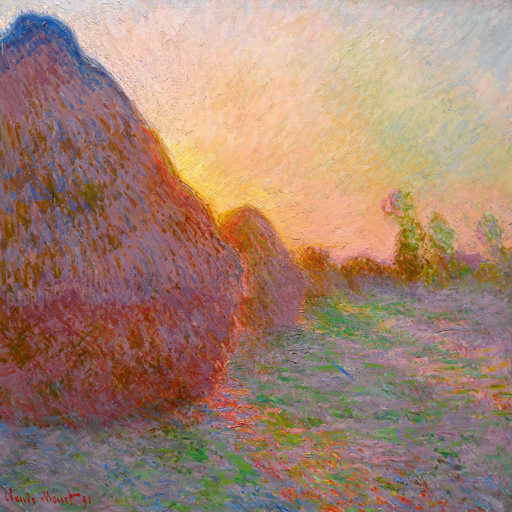

In [17]:
style_image = Image.open(next(iter(style_file)))
style_image = style_image.resize((width, height))
style_image

In [ ]:
content_array = np.asarray(content_image, dtype='float32')
# Expand dims to merge all three images into one structure later
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


Prepare the images for VGG. Could also use the VGG.preprocess_input function

In [ ]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]
print(content_array.shape)

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

(1, 512, 512, 3)


Define input variables:
- the content image is not changed
- the style image is not changed
- the combination image is changed by the optimizer

In [ ]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

Add all together for classification in VGG network

In [ ]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

In [ ]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

## Losses

Create variable for total loss

In [ ]:
loss = backend.variable(0.)

### Content loss
Johnson et.al. 2016 are using `block2_conv2`, Gatys et al. 2015 use `block4_conv2` -> looses more structural detail

In [ ]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layers = dict([(layer.name, layer.output) for layer in model.layers])
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = loss + content_weight * content_loss(content_image_features,
                                      combination_features)

### The style loss

Using gram matrix to keep pattern information -> We still have to understand that a bit


In [ ]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [ ]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### The total variation loss

Normalizing term

In [ ]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

## Optimizing step


In [ ]:
grads = backend.gradients(loss, combination_image)

In [ ]:
outputs = [loss]
outputs += grads
# create the computation function that is used to backpropagate to combination_image
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [ ]:
# Generate random noise for start image
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

# number of iterations (~50sec for first iteration, 6sec each after)
iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 116984920000.0
Iteration 0 completed in 6s
Start of iteration 1
Current loss value: 48067900000.0
Iteration 1 completed in 5s
Start of iteration 2
Current loss value: 33753494000.0
Iteration 2 completed in 6s
Start of iteration 3
Current loss value: 24994626000.0
Iteration 3 completed in 6s
Start of iteration 4
Current loss value: 19414706000.0
Iteration 4 completed in 6s
Start of iteration 5
Current loss value: 16350962000.0
Iteration 5 completed in 6s
Start of iteration 6
Current loss value: 14434384000.0
Iteration 6 completed in 6s
Start of iteration 7
Current loss value: 13403893000.0
Iteration 7 completed in 6s
Start of iteration 8
Current loss value: 12809439000.0
Iteration 8 completed in 6s
Start of iteration 9
Current loss value: 12455985000.0
Iteration 9 completed in 6s


In [ ]:
# undo the image preprocessing
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

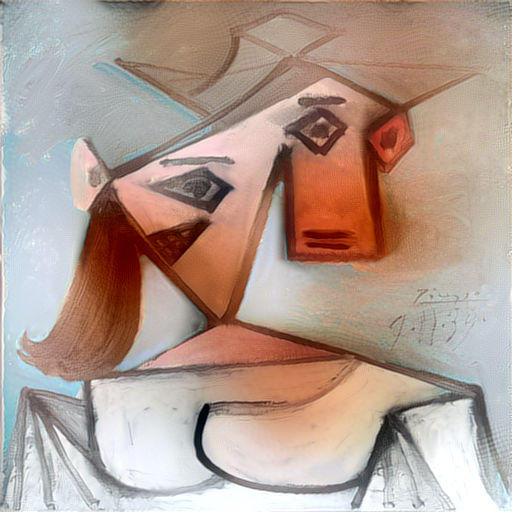

In [ ]:
im = Image.fromarray(x)
# im.save('result.png')
im